<a href="https://colab.research.google.com/github/harshad-leo/Dissertation_MA981/blob/main/KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph based Recommendation System. 


In [1]:
# Mounting googe colab
from google.colab import drive
drive.mount('drive')
PATH = '/content/drive/MyDrive/RecommendationSystems/'

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
#installing the libraries
%tensorflow_version 1.x
!pip install rdflib
!pip install networkx
!pip install q keras==1.2.2
import numpy as np
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
import rdflib as rd
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Merge
from keras.optimizers import Adam
from keras.models import Sequential
import warnings
import math
warnings.filterwarnings("ignore") #ignoring warnings (deprecation)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
enc = 'latin-1'
movies = pd.read_csv(PATH + "ml-25m/movies.csv", sep = "\t",  encoding = enc)
ratings = pd.read_csv(PATH + "ml-25m/ratings.csv", sep = "\t",  encoding=enc)
users = pd.read_csv(PATH + "ml-25m/users.csv", sep = "\t",  encoding=enc)
df = pd.read_csv(PATH + "ml-25m/main_merged.csv")

In [4]:
class networkx_viewer:
    def __init__(self,individual_list,total_class_dict,rdf_about):
        self.individual_list = individual_list
        self.total_class_dict = total_class_dict
        self.rdf_about = rdf_about

    def cquery(self,individual_name,path):
        
        g = rd.Graph()
        g.parse(path, format="xml")
        q = "SELECT ?p ?o  WHERE { <" + self.rdf_about + "#" + individual_name + "> ?p ?o .}"
        x = g.query(q)
        t = list(x)
        result = {}
        si = {}
        current_class = {}
        for i in t:
            dprop = i[0].split("#")[-1]
            dprop_val = i[1].split("#")[-1]
            if dprop_val != "NamedIndividual" and dprop != "type":
                if dprop_val in individual_list:
                    if dprop in si :
                        if type(si[dprop]) == str:
                            copy = si[dprop]
                            tmp = [copy,dprop_val]
                            si[dprop] = tmp
                        if type(si[dprop]) == list and dprop_val not in si[dprop]:
                            si[dprop].append(dprop_val)
                    else:
                        si[dprop] = dprop_val
                else:
                    a = str(i[1])
                    result[dprop] = a
            if dprop_val != "NamedIndividual" and dprop == "type":
                current_class["classtype"] = dprop_val
        return result,si,current_class

    def qct(self,individual_name,dict):
        g = rd.Graph()
        g.parse(PATH + "f1.rdf", format="xml")
        q = "SELECT ?p ?o  WHERE { ?p ?o <" + self.rdf_about + "#" + individual_name + ">.}"
        x = g.query(q)
        t = list(x)
        for i in t:
            class_name = i[1].split("#")[-1]
            dict[class_name] = class_name

        return dict



    def ind_classes(self,individual_list,total_class_dict):
        for i in individual_list:
            total_class_dict = self.qct(i,total_class_dict)
        return total_class_dict



In [5]:
def query_all_individuals(path):
    g = rd.Graph()
    g.parse(path, format="xml")
    q = "SELECT ?individual  WHERE {?individual rdf:type owl:NamedIndividual.}"
    x = g.query(q)
    t = list(x)
    result = []
    for i in t:
        result.append(i[0].split("#")[1])
    return result

def query_rdf_about(path):
    g = rd.Graph()
    result = g.parse(path, format="xml")
    for i in result:
        rdf_about = i[0].split("#")[0]
        break
    return rdf_about

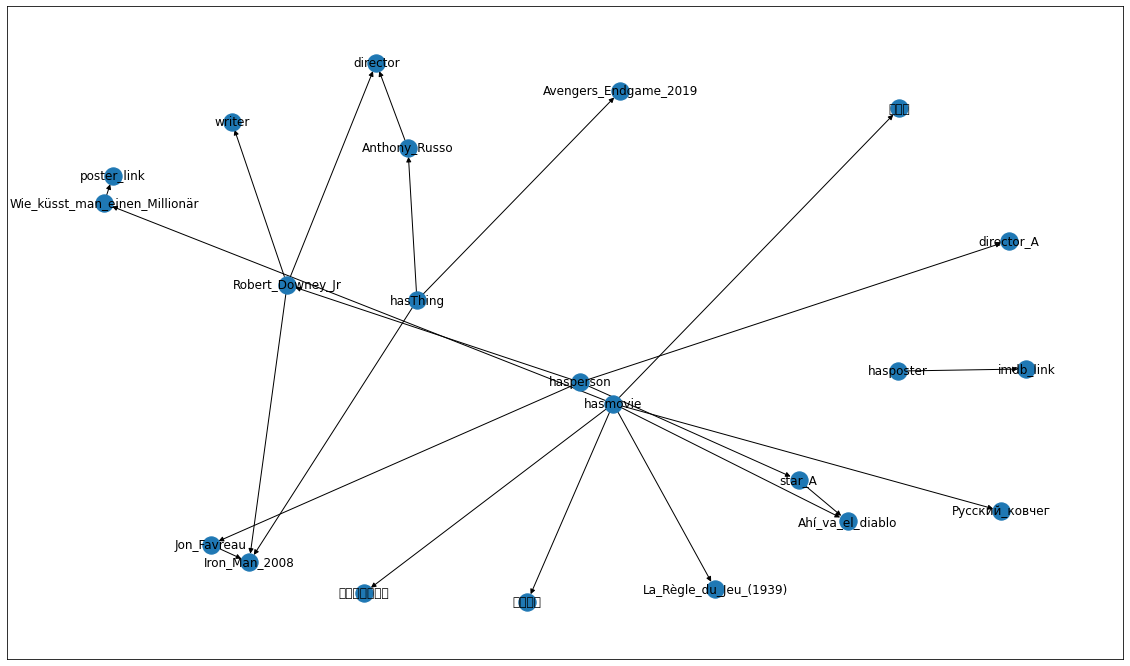

In [6]:
if __name__ == "__main__":
    a = {}
    G = nx.DiGraph()
    path = PATH + "f1.rdf"
    rdf_about = query_rdf_about(path)
    individual_list = query_all_individuals(path)
    total_class_dict = {}
    network_v = networkx_viewer(individual_list,total_class_dict,rdf_about)
    network_v.ind_classes(individual_list,total_class_dict)

    dict = {}
    for i in individual_list:
        if str(i) in dict:
            individual_name = dict[str(i)]
        else:
            G.add_node(i, name=str(i))
            dict[i] = i
            individual_name = i
        dprop_dict = network_v.cquery(str(i),path)[0]
        subindividual_dict = network_v.cquery(str(i),path)[1]
        current_class_type = network_v.cquery(str(i),path)[2]
        for dprop in dprop_dict:
            dprop_name = dprop_dict[dprop].split("#")[-1]
            G.add_node(individual_name, name=dprop_name)
            dict[dprop_name] = dprop_name

            G.add_edge(individual_name, dprop_name, dprop=str(dprop))

        for subindividual in subindividual_dict:
            if type(subindividual_dict[subindividual]) == str:
                if subindividual_dict[subindividual] in dict:
                    sub_individual = dict[subindividual_dict[subindividual]]
                else:
                    sub_individual = subindividual

                    G.add_node(sub_individual,name = sub_individual)
                    dict[sub_individual] = sub_individual

                G.add_edge(individual_name, sub_individual, property=str(subindividual.split("__")[-1]))

            if type(subindividual_dict[subindividual]) == list:
                for x in subindividual_dict[subindividual]:
                    if x in dict:
                        tmp4 = dict[str(x)]
                    else:
                        G.add_node(x, name=str(x))
                        dict[str(x)] = x
                    G.add_edge(individual_name, x, property=str(x))
        for class_type in current_class_type:
            if "has"+current_class_type[class_type] not in total_class_dict:
                current_class_name = "has"+current_class_type[class_type]
                G.add_node(current_class_name, classname="hassuper")
                tmp5 = "has"+current_class_type[class_type]
            else:
                if type(total_class_dict["has"+current_class_type[class_type]]) == int:
                    tmp5 = total_class_dict["has"+current_class_type[class_type]]
                else:
                    tmp5 = "has"+current_class_type[class_type]
                    total_class_dict["has"+current_class_type[class_type]] = tmp5
                    G.add_node(tmp5, classname=current_class_type[class_type])

            G.add_edge(tmp5, individual_name, property="class")
    plt.figure(figsize=(20, 12))
    nx.draw_networkx(G)
    plt.show()

In [7]:
class KGModel(Sequential):
  def __init__(self, n_users, m_items, k_factors, **kwargs):
      mod = Sequential()
      mod.add(Embedding(n_users, k_factors, input_length=1))
      mod.add(Reshape((k_factors,)))
      mod_ = Sequential()
      mod_.add(Embedding(m_items, k_factors, input_length=1))
      mod_.add(Reshape((k_factors,)))

      super(KGModel, self).__init__(**kwargs)
      self.add(Merge([mod, mod_], mode='dot', dot_axes=1))

  def rate(self, user_id, item_id):
      return self.predict([np.array([user_id]), np.array([item_id])])[0][0]


In [8]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
model = KGModel(max_userid, max_movieid, 100)
model.compile(loss='mse', optimizer='adamax')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [9]:
shuffled_ratings = ratings.sample(frac=1., random_state=40)
Users = shuffled_ratings['user_emb_id'].values
Movies = shuffled_ratings['movie_emb_id'].values
Ratings = shuffled_ratings['rating'].values

In [10]:
ep = 1
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint((PATH + 'weights.h5'), save_best_only = True)]
history = model.fit([Users, Movies], Ratings, nb_epoch = ep, validation_split = .1, verbose = 2, callbacks = callbacks)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Train on 900188 samples, validate on 100021 samples
Epoch 1/1





299s - loss: 8.2430 - val_loss: 2.2722


In [11]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 1 = 1.5074


In [12]:
trained_model = KGModel(max_userid, max_movieid, 100)
# weights = PATH + 'weights.h5'
# trained_model.load_weights('weights.h5')

In [13]:
TEST_USER = 2000
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_id,movie_id,rating,prediction,Unnamed: 0,title,genres
0,2000,1639,5,-0.004601,1593,Chasing Amy (1997),Drama|Romance
1,2000,2529,5,0.004685,2460,Planet of the Apes (1968),Action|Sci-Fi
2,2000,1136,5,-0.015886,1120,Monty Python and the Holy Grail (1974),Comedy
3,2000,2321,5,-0.003051,2252,Pleasantville (1998),Comedy
4,2000,2858,5,0.012725,2789,American Beauty (1999),Comedy|Drama
5,2000,2501,5,-0.016835,2432,October Sky (1999),Drama
6,2000,2804,5,0.002366,2735,"Christmas Story, A (1983)",Comedy|Drama
7,2000,1688,5,-0.005185,1642,Anastasia (1997),Animation|Children's|Musical
8,2000,1653,5,0.002775,1607,Gattaca (1997),Drama|Sci-Fi|Thriller
9,2000,527,5,-0.007473,523,Schindler's List (1993),Drama|War


In [14]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_id,prediction,Unnamed: 0,title,genres
0,2524,0.032184,2455,"Towering Inferno, The (1974)",Action|Drama
1,3799,0.030430,3730,Pokémon the Movie 2000 (2000),Animation|Children's
2,397,0.028288,393,"Fear, The (1995)",Horror
3,753,0.025768,743,"Month by the Lake, A (1995)",Comedy|Drama
4,2934,0.024285,2865,"Love Bewitched, A (El Amor Brujo) (1986)",Musical
5,2183,0.023487,2114,"Man Who Knew Too Much, The (1956)",Thriller
6,3945,0.023314,3875,Digimon: The Movie (2000),Adventure|Animation|Children's
7,2031,0.022993,1962,"$1,000,000 Duck (1971)",Children's|Comedy
8,3108,0.022409,3039,"Fisher King, The (1991)",Comedy|Drama|Romance
9,2015,0.022260,1946,"Absent Minded Professor, The (1961)",Children's|Comedy|Fantasy
